In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error, r2_score, mean_absolute_percentage_error, explained_variance_score, max_error
pd.set_option('display.max_columns', None)
from IPython.display import display
import lightgbm as lgb
import numpy as np


data = pd.read_parquet("house_price_data_13-05-2024.parquet")
data.head()

,title,link,description,garage,price,home_type,city,home_size,home_area,floor,elevator,price_per_sqr_meter,date,neighborhood
0,"Apartamento T3, Terreiro Esperança, Centro de...",https://www.idealista.pt/imovel/33396790/,A EMBAIXADA DA CASA Apresenta este apartamento...,False,1200,Apartamento,Almada,T3,31,0,False,38.709677,13-05-2024,Laranjeiro e Feijó
1,"Apartamento T3 na rua Martins Afonso de Sousa,...",https://www.idealista.pt/imovel/33281382/,Opção de mobília e equipamento de cozinha para...,False,1250,Apartamento,Almada,T3,90,1,False,13.888889,13-05-2024,Almada - Cova da Piedade - Pragal - Cacilhas
2,Apartamento T1 em Almada,https://www.idealista.pt/imovel/30954625/,Disponível a partir de 01 de Junho de 2024.\nE...,False,925,Apartamento,Almada,T1,65,8,True,14.230769,13-05-2024,Apartamento T1 em Almada
3,"Apartamento T2 em Santo António, Costa de Capa...",https://www.idealista.pt/imovel/32744859/,"T2 de 70m2, luminoso, mobilado e equipado na C...",False,1150,Apartamento,Almada,T2,71,1,False,16.197183,13-05-2024,Costa de Caparica
4,"Apartamento T2 na avenida Rainha Dona Leonor, ...",https://www.idealista.pt/imovel/33396657/,"Apartamento de 2 assoalhadas, totalmente remod...",False,1200,Apartamento,Almada,T2,72,0,False,16.666667,13-05-2024,Almada


In [4]:
selected_features = ["home_type", "garage", "home_size", "floor", "elevator", "city", "home_area"]
target = ["price"]

data = data[selected_features + target]

In [5]:
for c in data.columns:
    col_type = data[c].dtype
    if col_type == 'object' or col_type == 'bool':
        data[c] = data[c].astype('category')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2810 entries, 0 to 2809
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   home_type  2810 non-null   category
 1   garage     2810 non-null   category
 2   home_size  2810 non-null   category
 3   floor      2810 non-null   int64   
 4   elevator   2810 non-null   category
 5   city       2810 non-null   category
 6   home_area  2810 non-null   int64   
 7   price      2810 non-null   int64   
dtypes: category(5), int64(3)
memory usage: 81.6 KB


In [6]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns=target), 
                                                    data[target], 
                                                    test_size=0.25, 
                                                    random_state=42)

In [7]:
d_train=lgb.Dataset(X_train, 
                    label=y_train)

# Define parameters for LightGBM
params = {
    'objective': 'tweedie',
    'metric': 'rmse',  # Root Mean Squared Error    
    'n_estimators': 1000,
    'max_depth': 32,
    'num_leaves': 2**6,
    'learning_rate': 0.01
}

clf=lgb.train(params,
              d_train) 

c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001405 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 304
[LightGBM] [Info] Number of data points in the train set: 2107, number of used features: 7
[LightGBM] [Info] Start training from score 7.905215
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [8]:
# Prediction on the valid set
y_pred=clf.predict(X_test)

# postprocess function
# y_pred = y_pred.astype(np.int16)

In [9]:
def regression_scores(y_test, y_pred):
    scores = {}
    scores['mean_squared_error'] = mean_squared_error(y_test, y_pred)
    scores['root_mean_squared_error'] = mean_squared_error(y_test, y_pred, squared=False)
    scores['mean_absolute_error'] = mean_absolute_error(y_test, y_pred)
    scores['median_absolute_error'] = median_absolute_error(y_test, y_pred)
    scores['r2_score'] = r2_score(y_test, y_pred)
    scores['mean_absolute_percentage_error'] = mean_absolute_percentage_error(y_test, y_pred)
    scores['explained_variance_score'] = explained_variance_score(y_test, y_pred)
    scores['max_error'] = max_error(y_test, y_pred)

    return scores

In [10]:
regression_scores(y_test, y_pred)

c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'mean_squared_error': 2929246.7553236005,
 'root_mean_squared_error': 1711.5042376002464,
 'mean_absolute_error': 866.0751354859858,
 'median_absolute_error': 333.6544158785764,
 'r2_score': 0.7170226207127227,
 'mean_absolute_percentage_error': 0.290143700790773,
 'explained_variance_score': 0.7176638983900725,
 'max_error': 12942.886190195217}

Text(0.5, 1.0, 'Actual vs. Predicted')

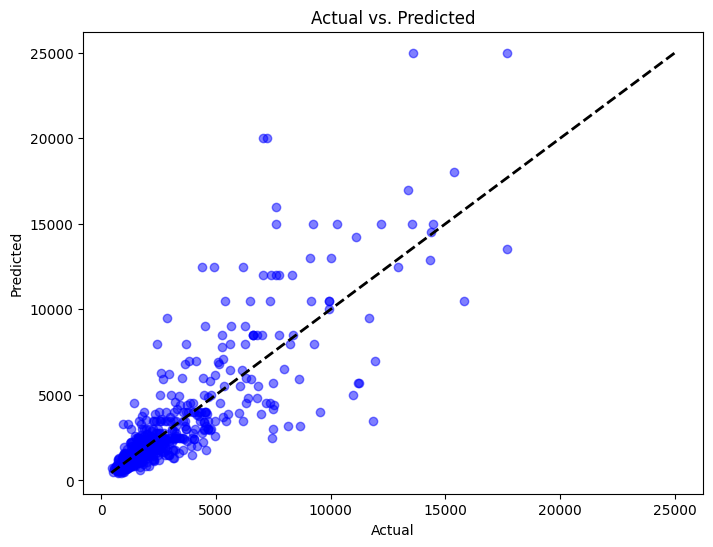

In [11]:
import matplotlib.pyplot as plt

# y_pred/y_test QQ plot
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, y_test, color='blue', alpha=0.5)
plt.plot([y_test.min(), 
          y_test.max()], 
          [y_test.min(), 
           y_test.max()], 
           'k--', 
           lw=2)  # Diagonal line
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted')

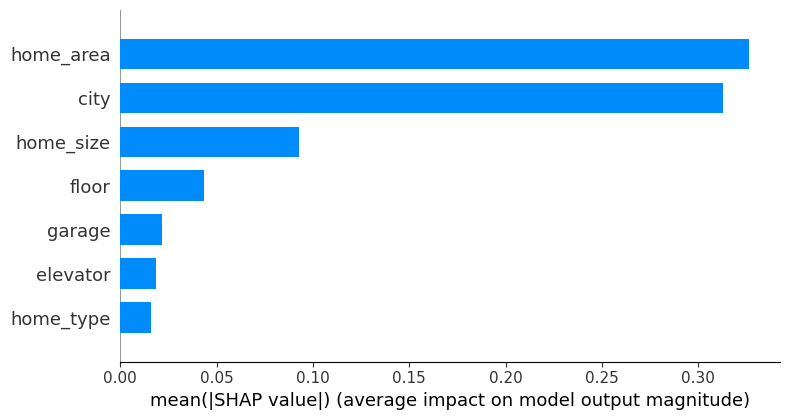

In [12]:
import shap

explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_test)
pd.DataFrame(shap_values, columns= X_test.columns).apply(np.abs).mean(axis = 0)

shap.summary_plot(shap_values, 
                  X_test, 
                  feature_names=X_test.columns,
                  plot_type = "bar")

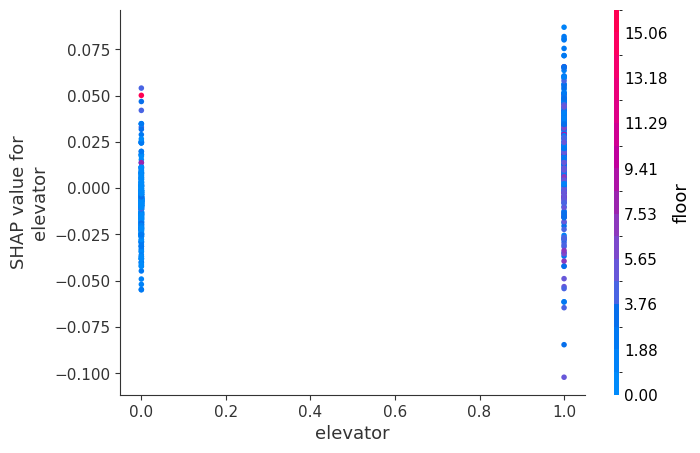

In [13]:
shap.dependence_plot("elevator", shap_values, X_test, interaction_index="floor")